In [2]:
#data format library
import h5py
#numpy
import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt
import sys
sys.path.append('/home/a/antonio-costa/BehaviorModel/utils')
import operator_calculations as op_calc
import worm_dynamics as worm_dyn
import stats
import h5py
import delay_embedding as embed
import operator_calculations as op_calc
import clustering_methods as cl

In [7]:
f = h5py.File('/bucket/StephensU/antonio/npr-1_data/resampled_results.h5','r')
print(list(f.keys()))
frameRate = np.array(f['new_frameRate'])[0]
dt = 1./frameRate
worm_labels = list(f.keys())[1:]
tseries_w=[]
for worm in worm_labels:
    ts = ma.masked_invalid(np.array(f[worm]))
    tseries_w.append(ts)
f.close()


masked_ts_w = []
for worm in np.arange(len(tseries_w)):
    ts_w = tseries_w[worm]
    ts_w[0] = ma.masked
    ts_w[-1] = ma.masked
    masked_ts_w.append(ts_w)

segments=op_calc.segment_maskedArray(ma.vstack(masked_ts_w),5)
omegas_all=ma.zeros(ma.vstack(masked_ts_w).shape[0])
a3s_all=ma.zeros(ma.vstack(masked_ts_w).shape[0])
for t0,tf in segments:
    phi,omega,a3=worm_dyn.compute_phi_omega_a3(ma.vstack(masked_ts_w),t0,tf,frameRate=frameRate)
    omegas_all[t0:tf] = omega
    a3s_all[t0:tf] = a3
omegas_all[omegas_all==0]=ma.masked
a3s_all[a3s_all==0]=ma.masked

eigenworms_matrix = np.loadtxt('/bucket/StephensU/antonio/ForagingN2_data/EigenWorms.csv', delimiter=',').astype(np.float32)
thetas_w = ma.array([ts.dot(eigenworms_matrix[:,:5].T) for ts in masked_ts_w])
thetas_all = ma.vstack(thetas_w)
thetas_sum = thetas_all.sum(axis=1)

['new_frameRate', 'npr-1 (ad609) on food R_2010_01_26__12_44_18___2___7', 'npr-1 (ad609)X on food  R_2010_01_25__16_08___3___10', 'npr-1 (ad609)X on food L_2010_01_22__11_33_10___2___5', 'npr-1 (ad609)X on food L_2010_01_26__12_44___3___7', 'npr-1 (ad609)X on food R_2010_01_22__11_34_25___8___5', 'npr-1 (ad609)X on food R_2010_01_22__11_35_12__5', 'npr-1 (ad609)X on food R_2010_01_26__12_44_50___4___7']


In [4]:
f = h5py.File('/home/a/antonio-costa/BehaviorModel/npr-1/embedding_analysis/partition_combined_results.h5','r')
K_range = np.array(f['K_range'],dtype=int)
seed_range = np.array(f['seed_range'],dtype=int)
prob_K_s = np.array(f['probs'])
H_K_s = np.array(f['entropies'])
h_K_s = np.array(f['entropy_rates'])
Ipred_K_s = np.array(f['Ipreds'])
eps_K_s = np.array(f['eps_scale'])
f.close()

In [5]:
def std_bootstrap(l,n_times): 
    new_means = []
    for i in range(n_times):
        indices=np.random.choice(range(0,len(l)),len(l))#len(l))
        new_list=[l[idx] for idx in indices]
        new_means.append(ma.mean(new_list,axis=0))
    new_means=ma.vstack(new_means)
    std = ma.std(new_means,axis=0)
    return ma.mean(l,axis=0),std

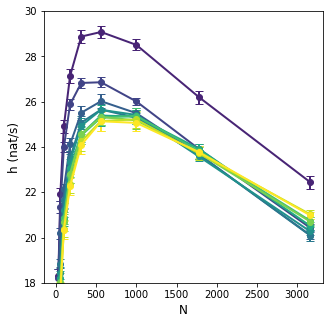

In [11]:
plt.figure(figsize=(5,5))
colors_K = plt.cm.viridis(np.linspace(.1,1,len(K_range[:22][::2])))
for k,K in enumerate(K_range[:22][::2]):
    mean,std = std_bootstrap(h_K_s[K-1,:13,:].T/dt,n_times=100)
    plt.errorbar(seed_range[:13],mean,std,c=colors_K[k],capsize=4,marker='o',lw=2)
plt.ylim(18,30)
plt.xlabel('N',fontsize=12)
plt.ylabel('h (nat/s)',fontsize=12)
# plt.savefig('h_N_Foraging_2K_N13.pdf')
plt.show()

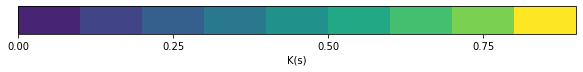

In [20]:
import matplotlib as mpl

fig, ax = plt.subplots(figsize=(10, 1))
fig.subplots_adjust(bottom=0.5)

cmap = mpl.colors.ListedColormap(colors_K)
cmap.set_over('0.1')
cmap.set_under('1.0')

bounds =  (K_range[:22][::2]-1)*dt
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
cb2 = mpl.colorbar.ColorbarBase(ax, cmap=cmap,
                                norm=norm,
                                boundaries=bounds,
                                ticks=np.arange(0,1.6,.25),
                                spacing='proportional',
                                orientation='horizontal')
cb2.set_label('K(s)')
# plt.savefig('colorbar_K_range_h_2K.pdf')
fig.show()


In [12]:
seed_range

array([  10,   17,   31,   56,  100,  177,  316,  562, 1000, 1778, 3162])

In [22]:
kN=7
h_K = h_K_s[:,kN,:]/dt

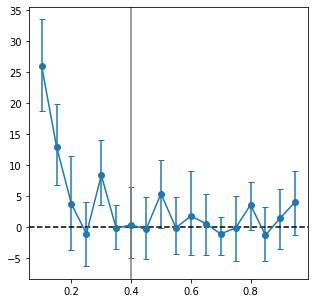

In [23]:
mean,cil,ciu = stats.bootstrap((-np.diff(h_K,axis=0).T/np.diff(K_range*dt)),n_times=1000)
plt.figure(figsize=(5,5))
plt.errorbar(K_range[1:-1]*dt,mean[1:],yerr = [mean[1:]-cil[1:],ciu[1:]-mean[1:]],capsize=3,marker='o')
plt.axhline(0,ls='--',c='k')
plt.axvline(8*dt,c='gray')
# plt.xlim(0,2.5)
# plt.text(2,13.5,'$N=10^3$',fontsize=14)
# plt.savefig('h_diff_Foraging_N_1000.pdf')
plt.show()